# DATA NOISE REMOVAL USING AUTOENCODERS
---

### IMPORTING PROJECT DEPENDENCIES
---
In this part, we will import all the necessary modules required for this project.

In [73]:
# modules for modeling and data manipulation
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# modules for viewing images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

If you encounter any error running the above given cell, comment out the below given cell and run it.

In [92]:
# !pip install numpy
# !pip install --upgrade tensorflow
# !pip install matplotlib

# # modules for modeling and data manipulation
# import numpy as np
# import tensorflow as tf
# import tensorflow.keras as keras
# from tensorflow.keras import layers
# from tensorflow.keras import backend as K

# # modules for viewing images
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

### IMPORTING THE DATASET
---

Let us now import the dataset and have a look at the number of data instances within out dataset.

In [74]:
# loading the MNIST dataset from keras' built-in dataset API
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# printing shapes of the dataset items
print("X_train's shape: {}".format(X_train.shape))
print("y_train's shape: {}".format(y_train.shape))
print("X_test's shape: {}".format(X_test.shape))
print("y_test's shape: {}".format(y_test.shape))


X_train's shape: (60000, 28, 28)
y_train's shape: (60000,)
X_test's shape: (10000, 28, 28)
y_test's shape: (10000,)


As we can see, the training data consists of 60,000 images of handwritten digits. The test set consists of 10,000 images.

Let us view some random images within our training dataset.

In [75]:
def display_random_images(data, num_images:int):
    """Displays random images from a dataset.
    Args-
        data: Image dataset
        num_images: Number of images to display
    Returns-
        None
    """
    max_lim, _, _ = data.shape

    fig, axes = plt.subplots(1, num_images, figsize=(4*num_images, 4), sharey=True)

    index_list = np.random.randint(0, max_lim, (num_images,))
    for index , ax in zip(index_list, axes):
        ax.imshow(data[index, :, :], cmap='gray')

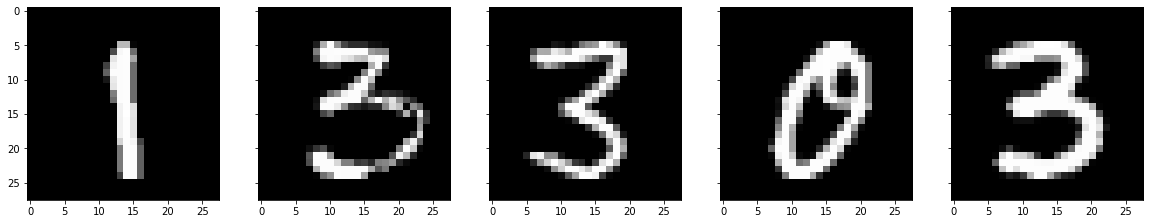

In [76]:
display_random_images(X_train, 5)

One thing that is clearly visible from these images is that there is little-to-no-noise within the images of our handwritten digits. __Hence, we need to manually induce some stochastic noise within the dataset so that we can train our de-noiser autoencoder.__ 

In the next section, let us create a 'noisy' dataset from our existing training set.

### ADDING STOCHASTIC (RANDOM) NOISE TO TRAINING SET
---
Before we define the function to add noise to the image data, let's first observe what an individual image looks like in terms of the numerical data of its pixels. This will help us determine the type of noise to add to the dataset.

In [77]:
# printing a 14x14 crop of the 28x28 pixel grayscale(single color channel) image
X_train[0, :14, :14]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170,
        253],
       [  0,   0,   0,   0,   0,   0,   0,  49, 238, 253, 253, 253, 253,
        253],
       [  0,   0,   0,   0,   0,   0,   0,  18, 219, 253, 253, 253, 253,
        253],
       [  0,   0,   0,   0,   0,   0,   0,   0,  80, 156, 107, 253, 253,
        205],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  14,   1, 154, 253,
         90],
       [  0,   0,   0,   0,   0,   0,   0, 

There are 2 observation here.
* The individual pixel values range from 0-255. In order to reduce this range, we need to scale/normalize the images.
* A pixel value of 0 denotes darker regions. Pixel values close to 255 denote brighter region. Since the actual digits are composed of brighter pixels, the noise that we have to introduce has to be on the brighter end of the grayscale spectrum.

Before we move any further, first let us scale the data. We will divide the pixel values by a factor of 255.0, which will reduce the scale from \[0,255] to just \[0,1].

__NOTE: Generally, the smaller the range of values the model has to deal with, the faster and more accurate the model's performance is.__ 

In [78]:
# re-scaling the data
X_train = X_train / 255.0
X_test = X_test / 255.0

Next, create a copy of the original training set, on which we are going to add the noise. This is important because otherwise the original data will get distorted which we don't want.

In [79]:
# creating copy of original training set
X_train_copy = np.copy(X_train)
X_test_copy = np.copy(X_test)

Now, let us finally define the method for adding noise to the dataset. 

In [80]:
def add_noise(training_data):
    """Adds noise to images.

    Args-
        training_data: Numpy array of training image data.
    Returns-
        noisy_data: Modified image data w/ noise.
    """
    m, n_H, n_W = training_data.shape
    noise_filter = np.random.rand(m, n_H, n_W) # creating the noise filter
    noisy_data = noise_filter + training_data # overlaying noise filter on training data
    return noisy_data

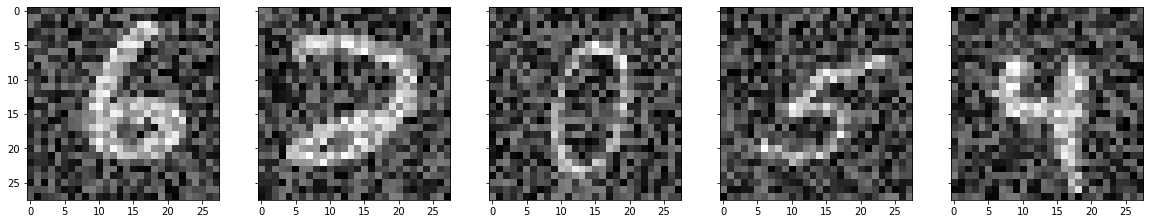

In [81]:
# creating noisy data
X_train_noisy = add_noise(X_train_copy)
X_test_noisy = add_noise(X_test_copy)

# printing samples from noisy data
display_random_images(X_train_noisy, 5)

Finally, we have a pretty noisy data. The initial work is over.

The next step is— Creating a neural network that will automatically remove the noise from the dataset, so that another model can recognize the digits within this noisy data. For this, we will be implementing an Autoencoder architecture.

Let's go ahead and implement this.

In [82]:
def build_model(n_W:int, n_H:int, n_C:int, filter_num_list:list, latent_dim:int):
    """Builds the autoencoder model for noise-removal.
    Args-
        n_W: Width dimension of input image
        n_H: Height dimension of input image
        n_C: Number of color channels (1 for grayscale; 3 for RGB)
        filter_num_list: Python list of filters
        latent_dim: Dimensions of the latent space at the core of autoencoder architecture
    Returns-
        encoder: Encoder part of the model
        decoder: Decoder part of the model
        autoencoder: Autoencoder model
    """
    input_shape = (n_W, n_H, n_C)

    ###############

    ## ENCODER PART OF MODEL

    # input layer 
    encoder_input = layers.Input(shape=input_shape, name='enc_input')
    X = encoder_input
    # convolution layers
    num = 0
    for filter in filter_num_list:
        num += 1
        X = layers.Conv2D(filters=filter, kernel_size=(3,3), strides=2, padding='same', activation='relu', name='conv_'+str(num))(X)
        X = layers.BatchNormalization(axis=-1, name='bn_'+str(num))(X)
    # flattening the convolved output
    shape_before_flatten = K.int_shape(X)[1:]
    X = layers.Flatten(name='flatten')(X)
    # Latent space as a dense layer (no activation function required)
    X = layers.Dense(latent_dim, name='latent_space')(X)
    latent_space = X
    encoder = keras.models.Model(inputs=encoder_input, outputs=latent_space, name='encoder')

    ###############

    ## DECODER PART OF MODEL

    # beginning with the latent space
    decoder_input = layers.Input(shape=(latent_dim,), name='dec_input')

    # expansion to original shape after flatten operation in encoder part
    X = layers.Dense(np.prod(shape_before_flatten), name='dense')(decoder_input)
    X = layers.Reshape(shape_before_flatten, name='shape_before_flatten')(X)
    # deconvolving 
    filtersRev = filter_num_list
    filtersRev.reverse()
    num = 0
    for filter in filtersRev:
        num += 1
        X = layers.Conv2DTranspose(filter, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', name='deconv_'+str(num))(X)
        X = layers.BatchNormalization(axis=-1, name='d_bn_'+str(num))(X)
    # number of channels in X is equal to the first filter in the filter_num_list
    # need to convert it to n_C number of channels using single-filter deconv operation
    X = layers.Conv2DTranspose(n_C, kernel_size=(3,3), padding='same', name='output')(X)
    X = layers.Activation('sigmoid')(X)
    
    decoder_output = X

    decoder = keras.models.Model(inputs=decoder_input, outputs=decoder_output, name='decoder')
    
    ###############
    ## COMPLETE ASSEMBLED AUTOENCODER
    autoencoder = keras.models.Model(inputs=encoder_input, outputs=decoder(encoder(encoder_input)), name='autoencoder')

    return encoder, decoder, autoencoder

In [83]:
encoder, decoder, autoencoder = build_model(28, 28, 1, [32, 64], 16)

With this, we have completed defining our model. Let us now have a look at the summary of our model.

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_input (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 14, 14, 32)        128       
_________________________________________________________________
conv_2 (Conv2D)              (None, 7, 7, 64)          18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 7, 7, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_space (Dense)         (None, 16)                5019

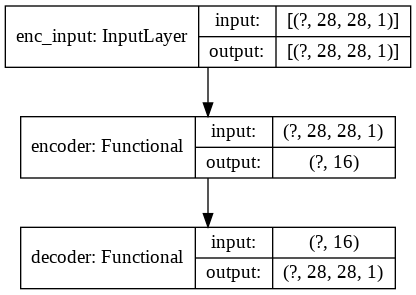

In [84]:
encoder.summary()
decoder.summary()
keras.utils.plot_model(autoencoder, 'model.png', show_shapes=True)

Let us now train the model.

In [85]:
autoencoder.compile(optimizer='adam', loss='mse')

# adding additional dimension to the training-noinsy data and original 
# traininig data to be used as label since both input and output should be
# of the shape (m, 28, 28, 1) 
x0, x1, x3 = X_train_copy.shape
X_train_copy = X_train_copy.reshape(x0, x1, x3, 1)
X_train_noisy = X_train_noisy.reshape(x0, x1, x3, 1)

autoencoder.fit(
    x = X_train_noisy, # input data is the noisy data
    y = X_train_copy, # non-noisy data to be used as target
    epochs = 40,
    callbacks = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    batch_size = 128,
    validation_split = 0.016, # around 1000 images 
    workers = 4,
)

Epoch 1/40
462/462 [==============================] - 4s 9ms/step - loss: 0.0340 - val_loss: 0.0190
Epoch 2/40
462/462 [==============================] - 4s 8ms/step - loss: 0.0139 - val_loss: 0.0125
Epoch 3/40
462/462 [==============================] - 4s 8ms/step - loss: 0.0121 - val_loss: 0.0115
Epoch 4/40
462/462 [==============================] - 4s 8ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 5/40
462/462 [==============================] - 4s 8ms/step - loss: 0.0107 - val_loss: 0.0102
Epoch 6/40
462/462 [==============================] - 4s 8ms/step - loss: 0.0103 - val_loss: 0.0104
Epoch 7/40
462/462 [==============================] - 4s 8ms/step - loss: 0.0100 - val_loss: 0.0102
Epoch 8/40
462/462 [==============================] - 4s 8ms/step - loss: 0.0098 - val_loss: 0.0105
Epoch 9/40
462/462 [==============================] - 4s 8ms/step - loss: 0.0096 - val_loss: 0.0116
Epoch 10/40
462/462 [==============================] - 4s 8ms/step - loss: 0.0094 - val_loss: 0.0102

Finally, let us use the autoencoder to eliminate the noise on the test data.

In [86]:
x0, x1, x3 = X_test_noisy.shape
X_test_noisy = X_test_noisy.reshape(x0, x1, x3, 1)

cleaned_X_test = autoencoder.predict(
    x = X_test_noisy,
    batch_size = 128,
    workers = 4,
)

x0, x1, x3, _ = cleaned_X_test.shape
cleaned_X_test = cleaned_X_test.reshape(x0, x1, x3)
X_test_noisy = X_test_noisy.reshape(x0, x1, x3)

Let us view some images to see how our model worked on cleaning the noise within the test dataset images.

Text(0.5, 1.0, 'De-noised image')

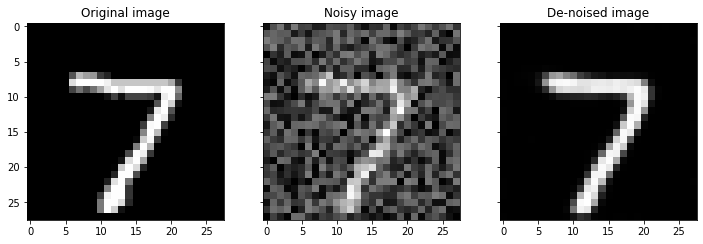

In [91]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12,4))
axes[0].imshow(X_test_copy[0, :, :], cmap='gray')
axes[0].set_title('Original image')
axes[1].imshow(X_test_noisy[0, :, :], cmap='gray')
axes[1].set_title('Noisy image')
axes[2].imshow(cleaned_X_test[0, :, :], cmap='gray')
axes[2].set_title('De-noised image')

As we can see, the de-noised result looks even better that the original image! With this, we come to the end of the first part of out project. In the second part, we will create a pipeline that can not only eliminate the noise, but also recognize the character/digit in the noisy image. 

### OCR PIPELINE
---

To be continued..